<a href="https://colab.research.google.com/github/iwatadive28/ESC-50-1DCNN/blob/main/ESC_50_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 環境の準備
Google Colabでの設定
Colabを開き、GPUを有効にします。
メニューから「ランタイム」 > 「ランタイムのタイプを変更」 > 「ハードウェア アクセラレータ」 > 「GPU」を選択。
必要なライブラリのインストール
以下を実行して、必要なライブラリをインストールします。



In [2]:
!pip install tensorflow librosa numpy matplotlib

# 2. データセットのダウンロード
ESC-50データセットをダウンロードして解凍します。

In [3]:
import os
import zipfile
import urllib.request

# ESC-50データセットのダウンロード
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
data_dir = "./ESC-50"
os.makedirs(data_dir, exist_ok=True)

zip_path = os.path.join(data_dir, "ESC-50.zip")
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

# 解凍
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

print("データセットの準備完了！")

データセットの準備完了！


# 3. 前処理
データとラベルの準備
ESC-50フォルダ内の音声ファイルをロードします。
ラベルを抽出し、データを分割します。

In [4]:
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# メタデータを読み込む
metadata_path = "./ESC-50/ESC-50-master/meta/esc50.csv"
metadata = pd.read_csv(metadata_path)

# パラメータ設定
SAMPLE_RATE = 16000  # サンプリングレート
DURATION = 5         # 音声の長さ（秒）

# 音声データのロード関数
def load_audio(file_path, label, sr=SAMPLE_RATE, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    # 長さを統一（ゼロパディング）
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    return y, label

# データ準備
audio_data = []
labels = []

base_path = "./ESC-50/ESC-50-master/audio/"
for index, row in metadata.iterrows():
    file_path = os.path.join(base_path, row["filename"])
    label = row["category"]
    y, lbl = load_audio(file_path, label)
    audio_data.append(y)
    labels.append(lbl)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)


In [7]:
y_train

['drinking_sipping',
 'engine',
 'footsteps',
 'cat',
 'cow',
 'clock_tick',
 'sheep',
 'mouse_click',
 'door_wood_knock',
 'laughing',
 'insects',
 'crying_baby',
 'dog',
 'sneezing',
 'hen',
 'laughing',
 'door_wood_creaks',
 'brushing_teeth',
 'snoring',
 'clapping',
 'washing_machine',
 'clock_alarm',
 'engine',
 'pig',
 'car_horn',
 'dog',
 'wind',
 'drinking_sipping',
 'snoring',
 'train',
 'keyboard_typing',
 'can_opening',
 'crow',
 'fireworks',
 'hand_saw',
 'drinking_sipping',
 'sheep',
 'can_opening',
 'hand_saw',
 'clock_alarm',
 'crickets',
 'chirping_birds',
 'dog',
 'footsteps',
 'footsteps',
 'mouse_click',
 'coughing',
 'snoring',
 'chirping_birds',
 'brushing_teeth',
 'rooster',
 'coughing',
 'vacuum_cleaner',
 'cat',
 'washing_machine',
 'toilet_flush',
 'clock_alarm',
 'pouring_water',
 'breathing',
 'clock_alarm',
 'keyboard_typing',
 'drinking_sipping',
 'rain',
 'vacuum_cleaner',
 'engine',
 'sneezing',
 'laughing',
 'engine',
 'pouring_water',
 'clock_alarm',
 '

# 4. モデル構築
1D-CNNを使用したモデルを構築します。

In [8]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# ラベルをエンコード
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# モデル構築
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(SAMPLE_RATE * DURATION, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 79998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 39999, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39997, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19998, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 19996, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           6,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,866 (636.20 KB)

 Trainable params: 162,866 (636.20 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
!pip install pydot graphviz

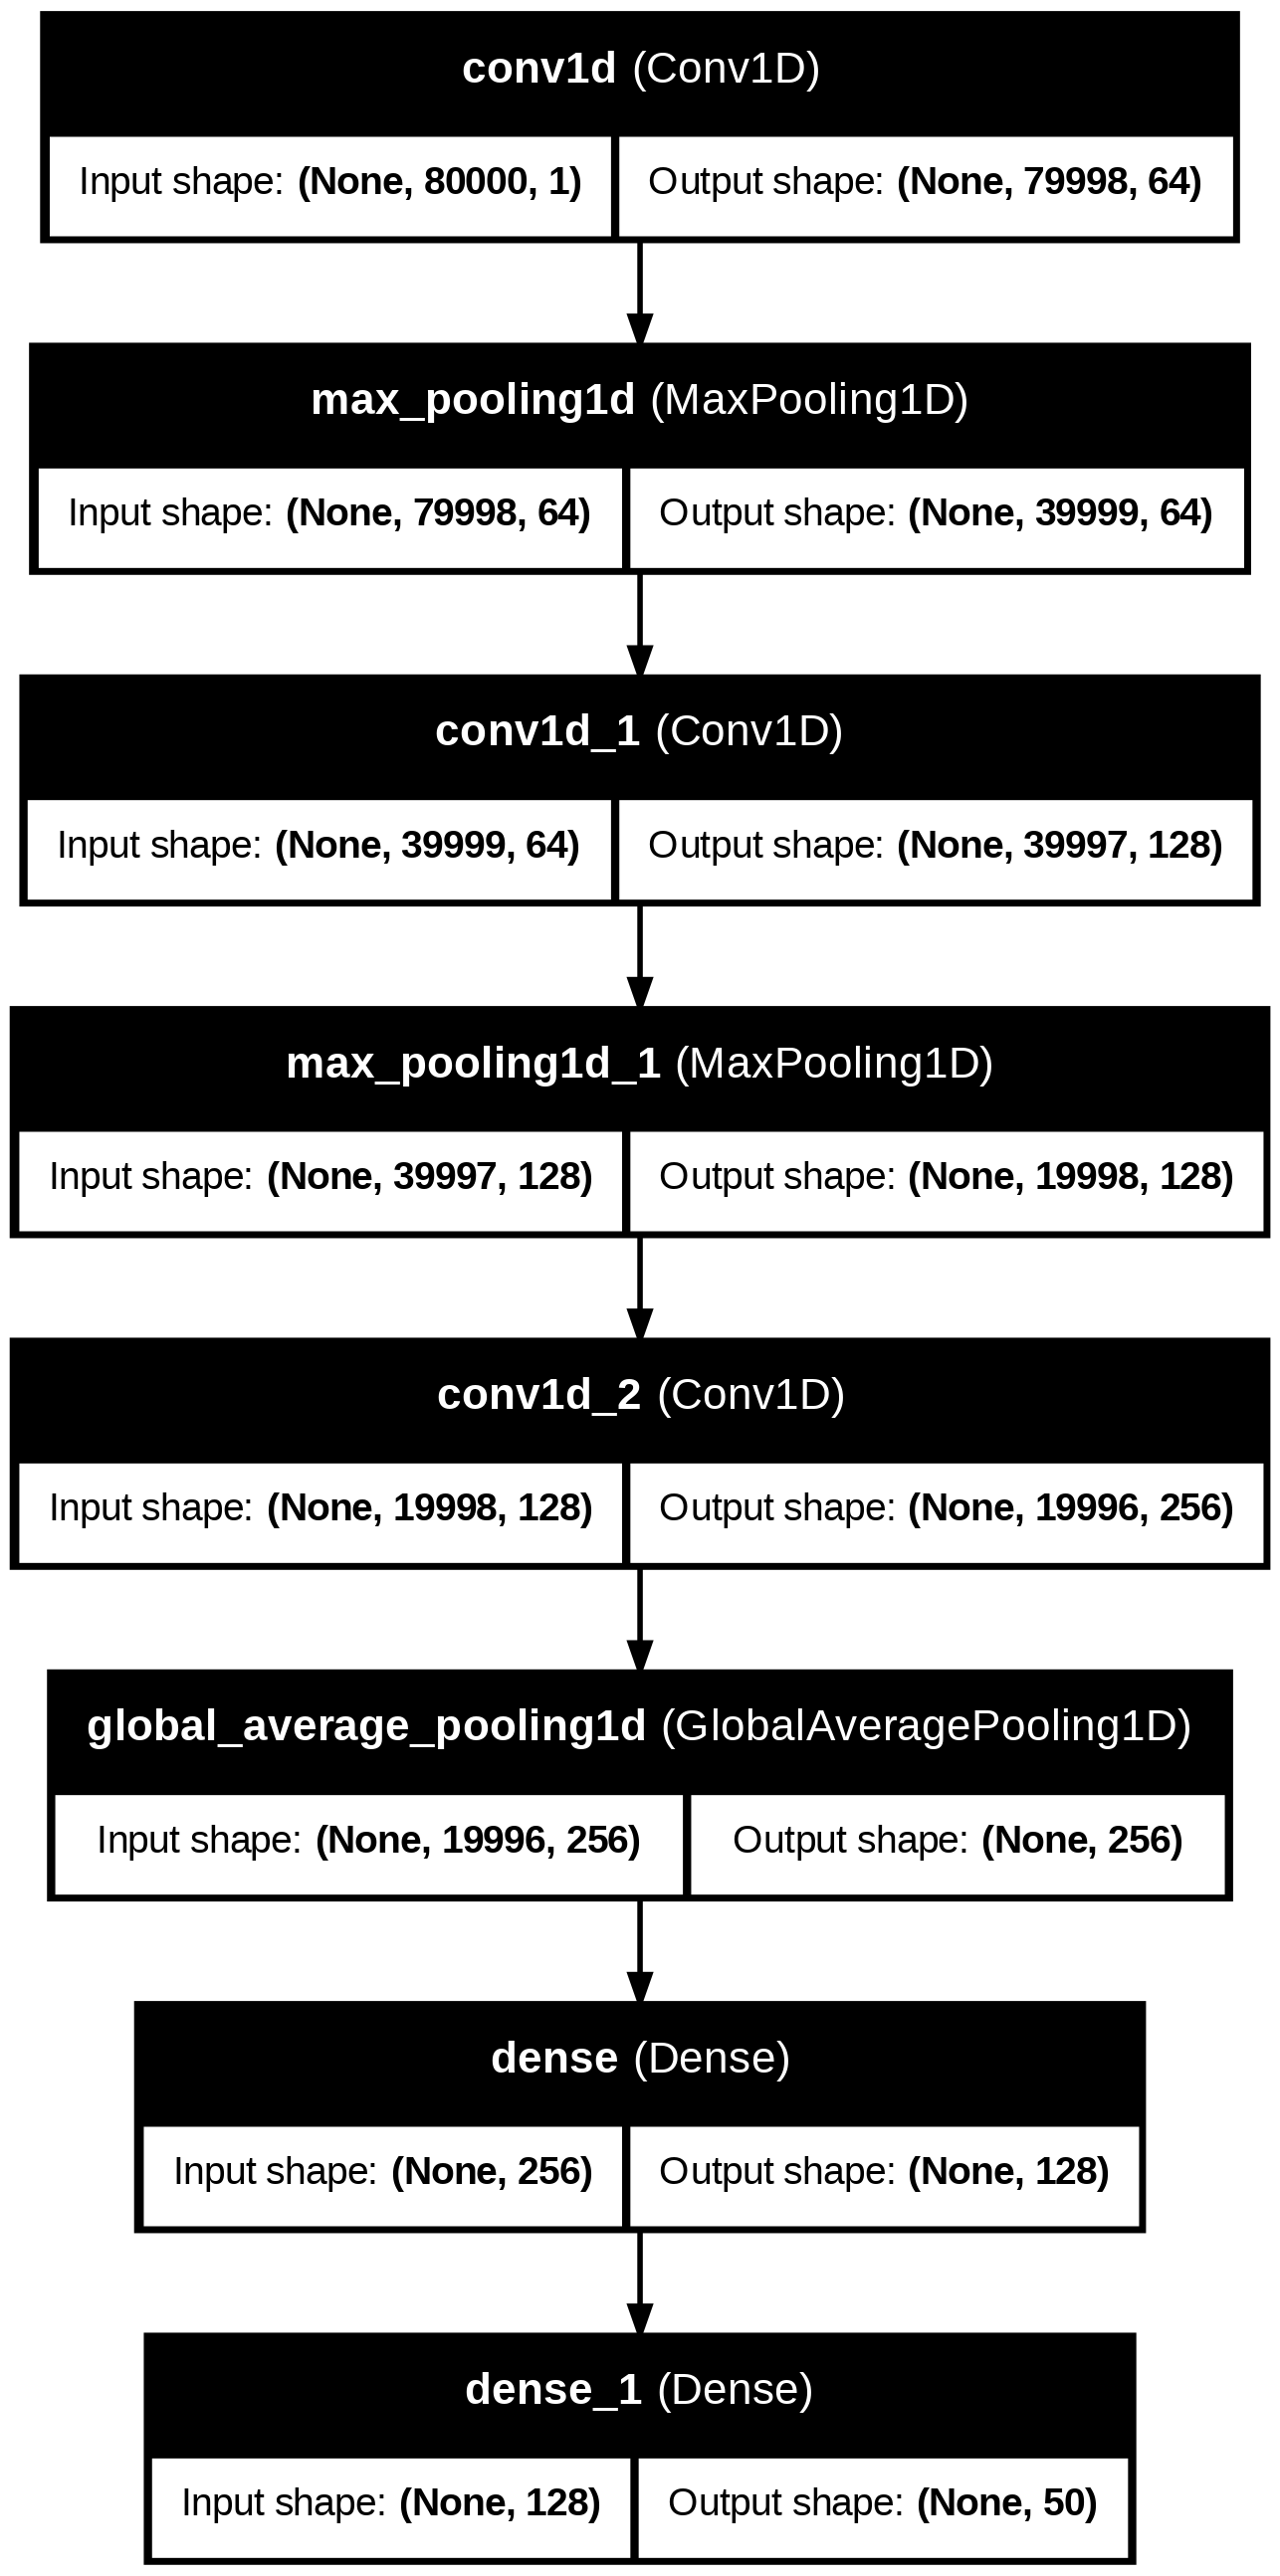

In [18]:
from tensorflow.keras.utils import plot_model
# モデル構造図の表示
plot_model(
    model,
    to_file="model_structure.png",  # ファイルに保存
    show_shapes=True,  # 入力と出力の形状を表示
    show_layer_names=True  # レイヤー名を表示
)

# Notebook内で画像を表示
from IPython.display import Image
Image("model_structure.png")


# 5. データの準備と訓練
データをモデルに適した形式に変換して訓練します。

Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2658 - loss: 2.4961
Epoch 1: val_loss improved from inf to 2.76855, saving model to trained_1d_cnn_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.2655 - loss: 2.4966 - val_accuracy: 0.2275 - val_loss: 2.7685
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.2654 - loss: 2.5235
Epoch 2: val_loss improved from 2.76855 to 2.75125, saving model to trained_1d_cnn_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.2653 - loss: 2.5236 - val_accuracy: 0.2200 - val_loss: 2.7512
モデルを保存しました: trained_1d_cnn_model.keras


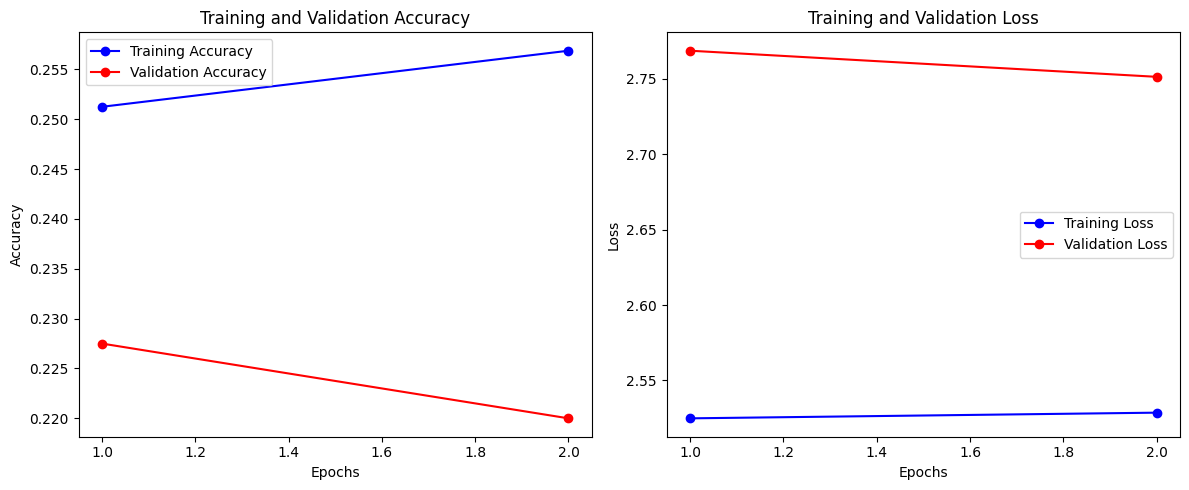

In [26]:
# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルの訓練時に保存するコールバック
checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,  # 保存先パスを変更
    monitor='val_loss',        # モニタリング対象
    save_best_only=True,       # ベストモデルのみ保存
    verbose=1                  # ログを出力
)

# モデルの訓練
history = model.fit(
    X_train,
    y_train_enc,
    epochs=2, #20
    batch_size=32,
    validation_data=(X_test, y_test_enc),
    callbacks=[checkpoint]  # コールバックを追加
)

# 訓練後、最終モデルを保存
model.save(MODEL_SAVE_PATH)
# `.h5`形式で保存
# model.save("trained_1d_cnn_model.h5", save_format="h5")

print(f"モデルを保存しました: {MODEL_SAVE_PATH}")

# 訓練履歴を可視化
def plot_training_history(history):
    """AccuracyとLossのグラフを表示"""
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracyのプロット
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Lossのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# グラフを表示
plot_training_history(history)

# 6. モデルの評価
保存形式が.kerasの場合も.h5の場合も、以下の方法でロードできます。
テストデータでモデルの性能を評価します。

In [27]:
from tensorflow.keras.models import load_model

# 保存済みモデルのロード
loaded_model = load_model(MODEL_SAVE_PATH)
print("モデルをロードしました。")
loaded_model.summary()


# テストデータで評価
test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"テストデータの損失: {test_loss}")
print(f"テストデータの精度: {test_acc}")


モデルをロードしました。


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 79998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 39999, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39997, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19998, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 19996, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           6,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 488,600 (1.86 MB)

 Trainable params: 162,866 (636.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 325,734 (1.24 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.1964 - loss: 2.8195
テストデータの損失: 2.751246452331543
テストデータの精度: 0.2199999988079071


# 7. 推論
新しい音声データをモデルで分類します。

In [28]:
# 推論関数
def predict_audio(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(y) < SAMPLE_RATE * DURATION:
        y = np.pad(y, (0, SAMPLE_RATE * DURATION - len(y)))
    y = y.reshape(1, -1, 1)
    predictions = model.predict(y)
    predicted_label = encoder.inverse_transform([np.argmax(predictions)])
    return predicted_label[0]

# 推論例
test_file = "./ESC-50/ESC-50-master/audio/1-100032-A-0.wav"
print(f"推論結果: {predict_audio(test_file)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
推論結果: can_opening


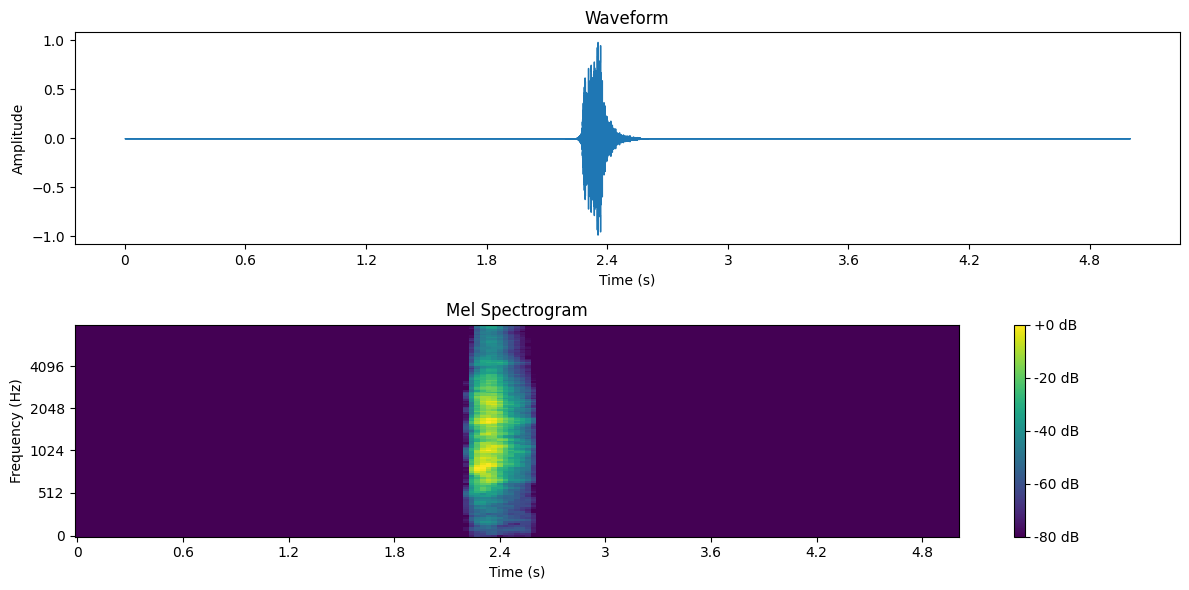

Audio Playback:


In [29]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

# 音声データの読み込み
y, sr = librosa.load(test_file, sr=16000)  # サンプリングレートを16kHzに指定

# スペクトログラムの計算
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# 波形とスペクトログラムの表示
plt.figure(figsize=(12, 6))

# 波形
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# スペクトログラム
plt.subplot(2, 1, 2)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

# 音声の再生
print("Audio Playback:")
display(Audio(y, rate=sr))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


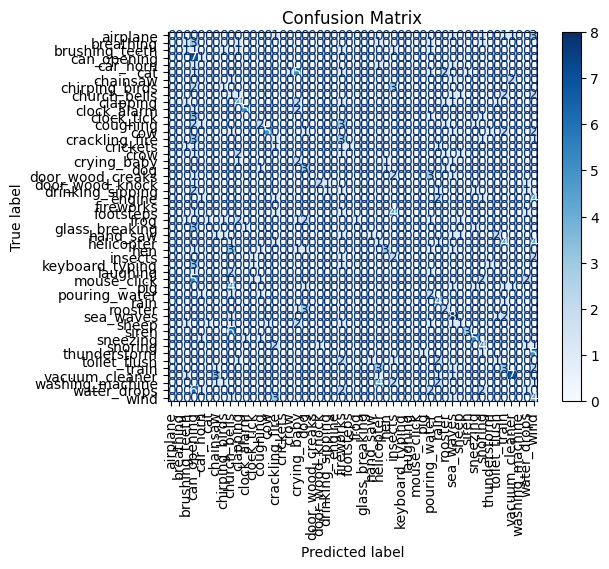

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 予測ラベルの取得
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 混同行列の計算
cm = confusion_matrix(y_test_enc, y_pred_classes, labels=range(len(encoder.classes_)))

# 混同行列の表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
